In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[4]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      BEZ.L
1      PSN.L
2      HSX.L
4      RS1.L
5      UTG.L
6     JMAT.L
7     BLND.L
8     FRAS.L
9     OCDO.L
10     CCL.L
11     IMI.L
12    INVP.L
13     HIK.L
14     ICP.L
15    DPLM.L
16     SXS.L
17    HWDN.L
18     EZJ.L
20     DPH.L
21    INCH.L
22     MKS.L
23    TATE.L
24     GAW.L
25    WIZZ.L
26     ITV.L
27     BWY.L
28     IGG.L
29     ROR.L
30     TUI.L
31     GRG.L
32    BBOX.L
33     VTY.L
34     CCC.L
Name: Ticker_Symbol, dtype: object

In [5]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [6]:
data = price_volume_data(symbols_short.to_list(),'2018-05-24', '2023-05-30')
data.pv

{'BEZ.L':                                  Open        High         Low       Close  \
 Date                                                                        
 2018-05-24 00:00:00+01:00  549.611481  555.545824  549.611481  551.893921   
 2018-05-25 00:00:00+01:00  551.894000  556.915369  550.981024  555.089417   
 2018-05-29 00:00:00+01:00  549.611578  551.894018  538.655866  540.025330   
 2018-05-30 00:00:00+01:00  538.199347  543.220715  536.373395  542.307739   
 2018-05-31 00:00:00+01:00  543.220788  548.698645  542.307812  545.959717   
 ...                               ...         ...         ...         ...   
 2023-05-22 00:00:00+01:00  622.500000  625.000000  617.500000  619.000000   
 2023-05-23 00:00:00+01:00  615.500000  624.549988  612.702026  619.000000   
 2023-05-24 00:00:00+01:00  614.000000  616.500000  601.000000  603.500000   
 2023-05-25 00:00:00+01:00  603.000000  610.500000  598.500000  606.500000   
 2023-05-26 00:00:00+01:00  614.000000  619.000000  599

In [7]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [8]:
df

Ticker_Symbol,BEZ.L,PSN.L,HSX.L,RS1.L,UTG.L,JMAT.L,BLND.L,FRAS.L,OCDO.L,CCL.L,...,WIZZ.L,ITV.L,BWY.L,IGG.L,ROR.L,TUI.L,GRG.L,BBOX.L,VTY.L,CCC.L
2018-05-24,551.893921,1651.625000,1324.572510,650.142639,725.681458,2927.962158,528.155579,421.600006,873.799988,4483.238281,...,3229.0,124.246040,2628.457764,586.301880,309.956085,15594.868164,905.403992,116.486290,934.178345,1170.480103
2018-05-25,555.089417,1673.419189,1336.804688,634.468018,734.752441,2885.772461,533.759338,421.899994,886.599976,4530.981445,...,3465.0,125.516541,2675.665527,594.513489,306.422852,15594.868164,914.018555,116.486290,951.776611,1175.651489
2018-05-29,540.025330,1658.104370,1311.466553,627.521301,723.521667,2851.177002,524.886658,411.200012,874.400024,4445.595215,...,3402.0,121.480881,2620.456055,570.207397,301.034576,15450.555664,906.265442,116.172523,925.379089,1161.860962
2018-05-30,542.307739,1666.350708,1315.835083,625.383850,727.841125,2866.365234,524.886658,407.500000,887.599976,4446.513672,...,3325.0,121.929260,2628.457764,570.535828,296.529694,15590.359375,923.494812,117.035416,925.745728,1154.965454
2018-05-31,545.959717,1668.117920,1312.340332,626.808777,733.888550,2964.245605,527.688477,406.700012,898.000000,4441.004883,...,3402.0,121.518242,2626.857178,567.908203,294.763031,15757.220703,909.711182,117.662933,923.545959,1152.081055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,619.000000,1283.367188,1156.726196,838.092834,902.833923,1845.725098,344.447815,748.500000,403.399994,787.799988,...,2979.0,72.614403,2412.448486,668.108154,334.267334,530.799988,2696.218018,141.735245,813.000000,2381.957275
2023-05-23,619.000000,1261.781494,1162.668335,779.520691,909.251038,1851.056763,353.435944,717.000000,402.600006,798.599976,...,2917.0,72.633896,2379.105713,666.679565,328.716034,548.200012,2668.401367,144.500809,790.000000,2312.013916
2023-05-24,603.500000,1192.118652,1140.880615,775.196594,883.089050,1804.041138,344.641113,705.500000,411.799988,743.200012,...,2850.0,70.899414,2283.000000,654.774597,323.561249,528.400024,2636.611084,139.265991,751.500000,2263.442383
2023-05-25,606.500000,1196.533936,1151.774536,784.041382,874.697510,1745.877563,340.678619,683.500000,402.899994,778.400024,...,2900.0,70.587593,2284.000000,648.107788,319.596039,528.400024,2640.584717,136.006561,751.000000,2240.127930


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [10]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [11]:
########################################

In [12]:
df_standardised = df.iloc[:-7].apply(lambda price: (price.iloc[:-7] - price.iloc[:-7].mean())/price.iloc[:-7].std())
df_standardised




Ticker_Symbol,BEZ.L,PSN.L,HSX.L,RS1.L,UTG.L,JMAT.L,BLND.L,FRAS.L,OCDO.L,CCL.L,...,WIZZ.L,ITV.L,BWY.L,IGG.L,ROR.L,TUI.L,GRG.L,BBOX.L,VTY.L,CCC.L
2018-05-24,0.898123,-0.214516,1.015868,-0.598249,-1.547388,1.264565,1.517138,-0.353120,-0.840395,1.859103,...,-0.263687,1.607770,0.348723,-0.172147,0.650948,2.620640,-1.726886,-0.853815,0.658973,-1.111884
2018-05-25,0.930706,-0.162127,1.061779,-0.675394,-1.476722,1.167708,1.609187,-0.351593,-0.818931,1.895879,...,-0.006374,1.666968,0.460059,-0.107247,0.553309,2.620640,-1.711516,-0.853815,0.760547,-1.103013
2018-05-29,0.777108,-0.198941,0.966678,-0.709584,-1.564213,1.088287,1.463442,-0.406063,-0.839388,1.830107,...,-0.075063,1.478928,0.329852,-0.299350,0.404408,2.583860,-1.725349,-0.862765,0.608185,-1.126669
2018-05-30,0.800380,-0.179118,0.983074,-0.720104,-1.530563,1.123155,1.463442,-0.424899,-0.817254,1.830814,...,-0.159017,1.499821,0.348723,-0.296754,0.279918,2.619491,-1.694607,-0.838150,0.610302,-1.138498
2018-05-31,0.837616,-0.174870,0.969957,-0.713091,-1.483452,1.347862,1.509465,-0.428972,-0.799815,1.826571,...,-0.075063,1.480669,0.344949,-0.317522,0.231097,2.662019,-1.719201,-0.820248,0.597605,-1.143446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,1.342745,-1.085573,0.366524,0.658586,0.174933,-1.087544,-0.805165,1.412845,-1.458480,-1.090203,...,-0.490471,-0.513760,-0.271736,0.715281,1.043356,-1.224697,1.652778,0.141562,-0.216485,0.706301
2023-05-02,1.291763,-0.914581,0.351898,0.617957,0.059569,-1.202156,-0.933757,1.443389,-1.475248,-1.076338,...,-0.463214,-0.655417,-0.174596,0.602372,0.988568,-1.224340,1.702410,0.058035,-0.147223,0.756292
2023-05-03,1.286665,-0.949959,0.406748,0.494135,0.105715,-1.196592,-0.909944,1.471388,-1.488495,-1.065554,...,-0.478478,-0.648153,-0.239356,0.617426,0.988568,-1.224188,1.762679,0.077524,-0.216485,0.749627
2023-05-04,1.199996,-0.978261,0.292968,0.310336,0.071105,-1.213283,-0.914706,1.438298,-1.497047,-1.078340,...,-0.499194,-0.673579,-0.285613,0.587318,1.026919,-1.224035,1.720136,0.049682,-0.259774,0.746294


In [13]:
# actual_price_ls = []
# for column in df.columns:
#     actual_price_ls.append((df[column].iloc[-1] - df[column].mean()) / df[column].std())
# actual_price_df = pd.DataFrame(index = df.columns)
# actual_price_df["actual_price"] = actual_price_ls

# actual_price_df

actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-7].mean()
    ticker_std_dict[column] = df[column].iloc[:-7].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls

actual_price_df

,actual_price
Ticker_Symbol,
BEZ.L,1.468969
PSN.L,-1.286969
HSX.L,0.392203
RS1.L,0.085076
UTG.L,-0.386824
JMAT.L,-1.464454
BLND.L,-1.661885
FRAS.L,0.910854
OCDO.L,-1.607938


In [14]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    #.iloc[:-7]
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2283.229, Time=5.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2281.918, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2281.918, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2285.216, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2279.918, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.086 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  BEZ.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1143.608
Date:                Sat, 21 Oct 2023   AIC                          -2285.216
Time:                        14:15:20   BIC                          -2280.088
Sample:                             0   HQIC                         -2283.288
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0093      0.000     45.882      0.000       0.009       0.010
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):              1193.39
Prob(Q):                              0.41   Pr

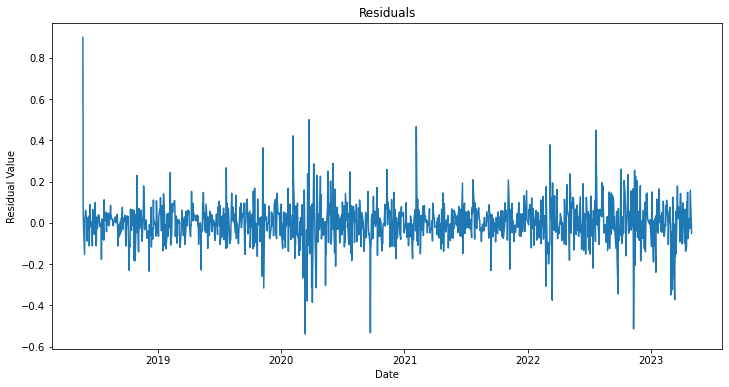

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2308.818, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2307.387, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2307.358, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2310.775, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2306.624, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.739 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PSN.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1156.387
Date:                Sat, 21 Oct 2023   AIC                          -2310.775
Time:                        14:15:23   BIC                          -2305.647
Sample:                             0   HQIC                         -2308.847
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0091      0.000     41.539      0.000       0.009       0.010
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               651.52
Prob(Q):                              0.45   Pr

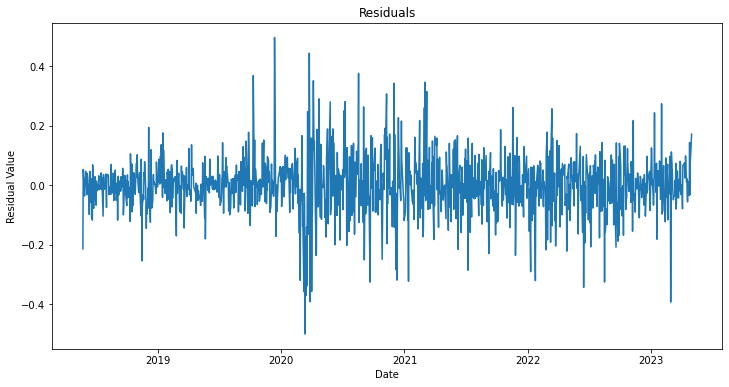

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2855.497, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2855.048, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2855.253, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2857.437, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2856.316, Time=1.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.591 seconds
                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1429.718
Date:                Sat, 21 Oct 2023   AIC                          -2857.437
Time:                        14:15:26   BIC                          -2852.309
Sample:                             0   HQIC                         -2855.509
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


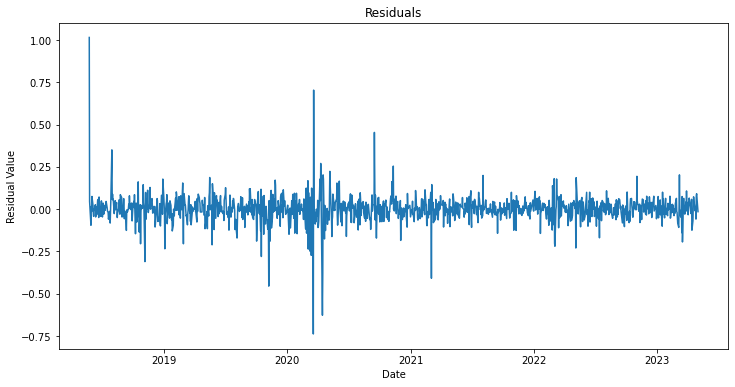

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2996.773, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2996.760, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2996.702, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2998.541, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2994.819, Time=0.79 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.988 seconds
                               SARIMAX Results                                
Dep. Variable:                  RS1.L   No. Observations:                 1237
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1500.271
Date:                Sat, 21 Oct 2023   AIC                          -2998.541
Time:                        14:15:29   BIC                          -2993.421
Sample:                             0   HQIC                         -2996.615
                               - 1237                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


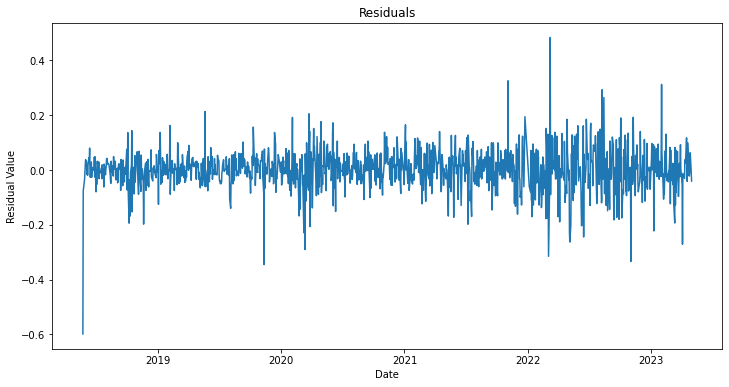

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1449.838, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1456.413, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1455.747, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1451.724, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1455.944, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1455.070, Time=1.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1455.254, Time=1.89 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1458.317, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1457.855, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1456.978, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1457.649, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1457.165, Time=0.76 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.021 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


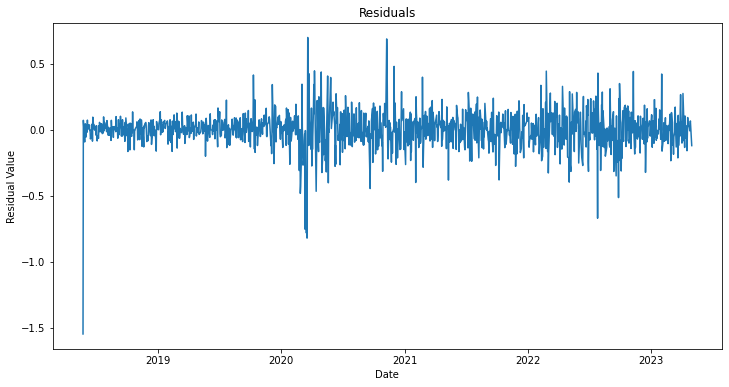

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1933.434, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1932.728, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1932.785, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1935.035, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1931.596, Time=1.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.174 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1242
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 968.518
Date:                Sat, 21 Oct 2023   AIC                          -1935.035
Time:                        14:15:40   BIC                          -1929.911
Sample:                             0   HQIC                         -1933.108
                               - 1242                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


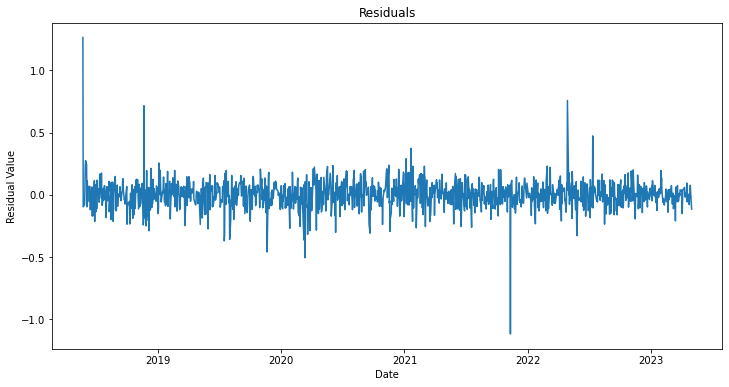

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1433.514, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1431.546, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1431.545, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1435.253, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1429.545, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.734 seconds
                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 718.627
Date:                Sat, 21 Oct 2023   AIC                          -1435.253
Time:                        14:15:43   BIC                          -1430.125
Sample:                             0   HQIC                         -1433.325
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


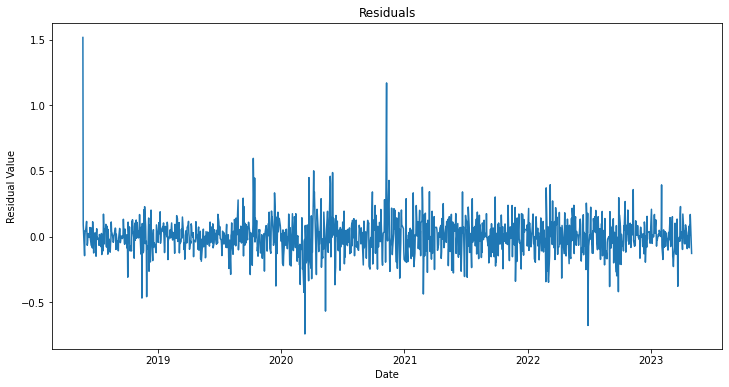

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3170.447, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3169.465, Time=1.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3169.424, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3171.882, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3167.999, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.725 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1586.941
Date:                Sat, 21 Oct 2023   AIC                          -3171.882
Time:                        14:15:46   BIC                          -3166.754
Sample:                             0   HQIC                         -3169.954
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0046   3.72e-05    123.110      0.000       0.005       0.005
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):            113557.88
Prob(Q):                              0.31   Pr

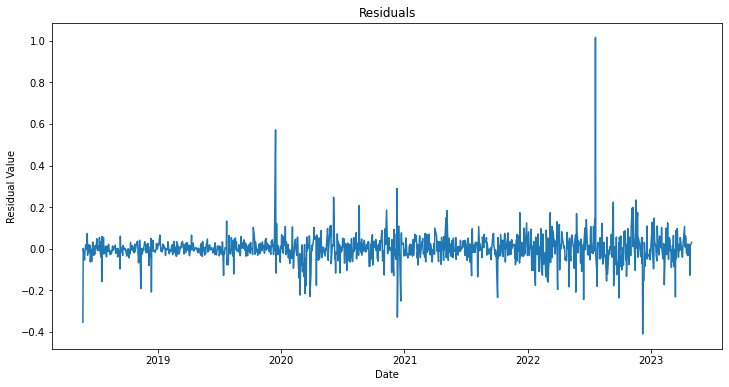

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3053.264, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3051.632, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3051.644, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3055.199, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3049.679, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.532 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 OCDO.L   No. Observations:                 1246
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1528.600
Date:                Sat, 21 Oct 2023   AIC                          -3055.199
Time:                        14:15:48   BIC                          -3050.072
Sample:                             0   HQIC                         -3053.271
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0050      0.000     48.437      0.000       0.005       0.005
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              1607.93
Prob(Q):                              0.54   Pr

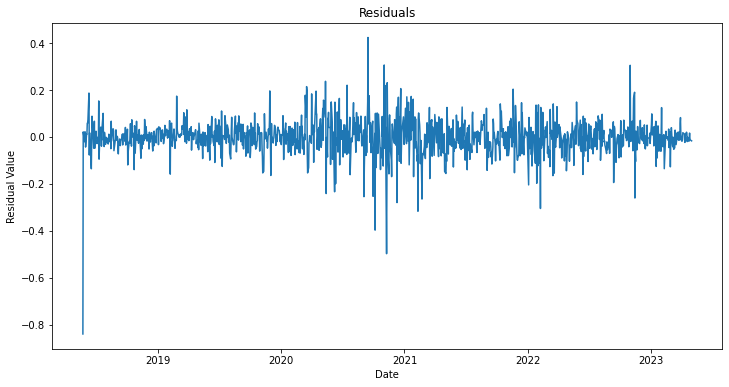

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3818.800, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3818.041, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3817.930, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3818.263, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3815.851, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.229 seconds
                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1910.131
Date:                Sat, 21 Oct 2023   AIC                          -3818.263
Time:                        14:15:51   BIC                          -3813.135
Sample:                             0   HQIC                         -3816.335
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


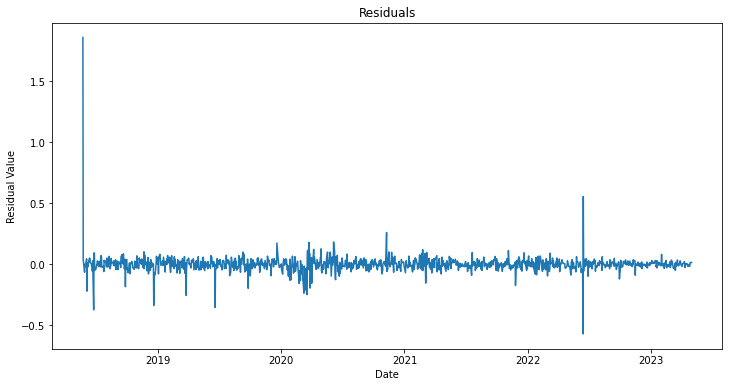

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3002.599, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3000.880, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3000.874, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3003.991, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2998.735, Time=0.79 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.786 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1502.995
Date:                Sat, 21 Oct 2023   AIC                          -3003.991
Time:                        14:15:54   BIC                          -2998.863
Sample:                             0   HQIC                         -3002.063
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


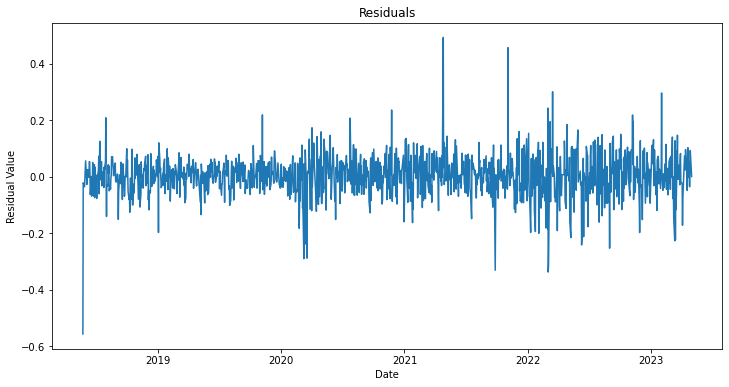

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3364.396, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3363.003, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3362.913, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3366.163, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3364.694, Time=1.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.849 seconds
                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1684.082
Date:                Sat, 21 Oct 2023   AIC                          -3366.163
Time:                        14:15:58   BIC                          -3361.035
Sample:                             0   HQIC                         -3364.235
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


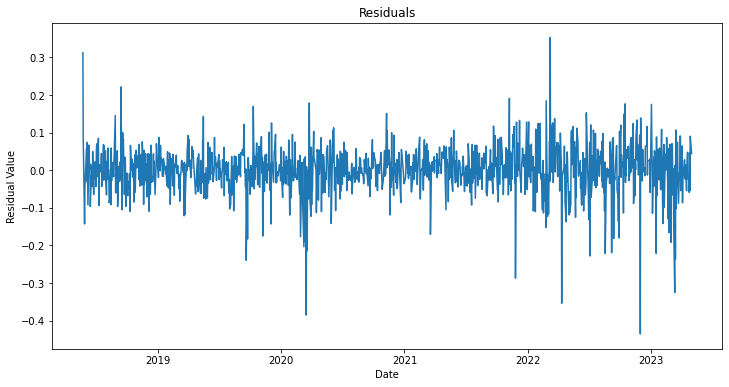

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2187.474, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2187.221, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2187.321, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2189.240, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2185.992, Time=1.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.509 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1246
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1095.620
Date:                Sat, 21 Oct 2023   AIC                          -2189.240
Time:                        14:16:01   BIC                          -2184.113
Sample:                             0   HQIC                         -2187.312
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0101      0.000     43.298      0.000       0.010       0.011
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):               849.97
Prob(Q):                              0.19   Pr

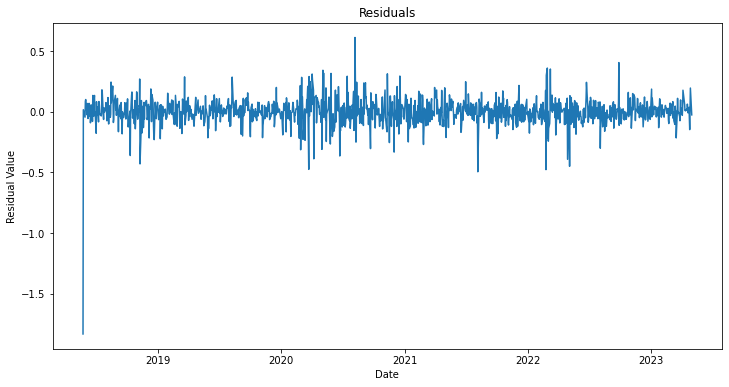

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2492.496, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2490.968, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2490.917, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2494.439, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2491.654, Time=1.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.950 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1248.220
Date:                Sat, 21 Oct 2023   AIC                          -2494.439
Time:                        14:16:05   BIC                          -2489.311
Sample:                             0   HQIC                         -2492.511
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0079      0.000     46.953      0.000       0.008       0.008
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              1437.98
Prob(Q):                              0.49   Pr

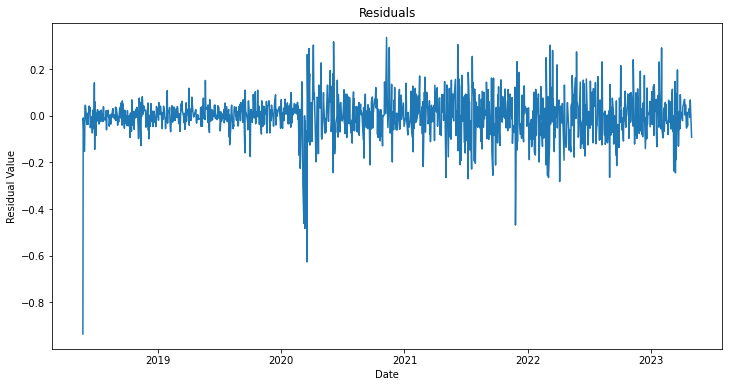

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3143.209, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3142.318, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3142.294, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3144.149, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3140.295, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.994 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1573.074
Date:                Sat, 21 Oct 2023   AIC                          -3144.149
Time:                        14:16:08   BIC                          -3139.021
Sample:                             0   HQIC                         -3142.221
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


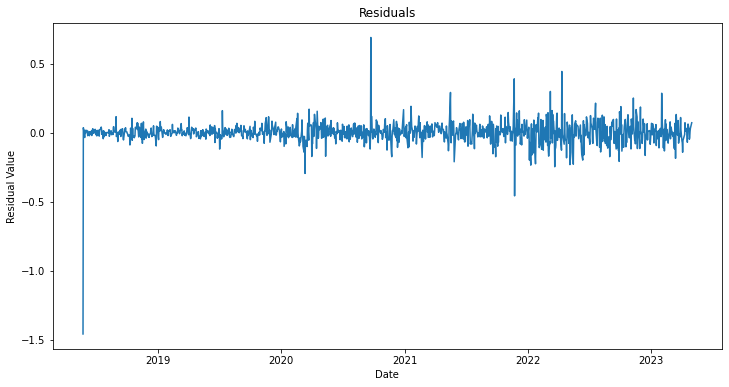

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2507.799, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2510.031, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2509.848, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2509.140, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2508.685, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2509.401, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2507.433, Time=2.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2511.294, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2509.980, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2510.689, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2511.110, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2508.723, Time=0.93 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.164 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SXS.L   No. Observations:                 1247
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1257.647
Date:                Sat, 21 Oct 2023   AIC                          -2511.294
Time:                        14:16:16   BIC                          -2501.039
Sample:                             0   HQIC                         -2507.438
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0577      0.024     -2.427      0.015      -0.104      -0.011
sigma2         0.0078      0.000     39.329      0.000       0.007       0.008
Ljung-Box (L1) (Q):                   0.00   Jarque-

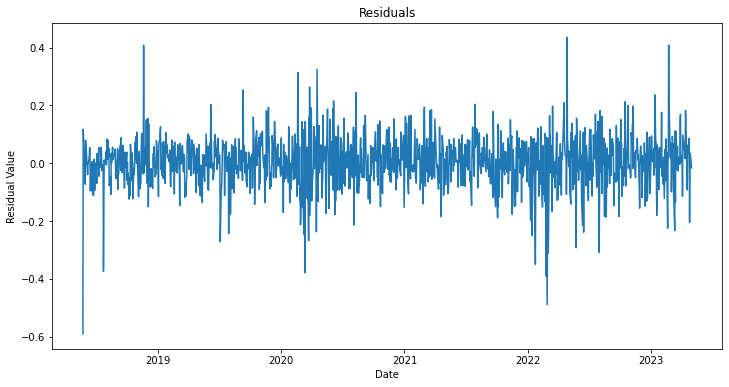

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2714.954, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2715.492, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2715.222, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2716.529, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2714.603, Time=1.89 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.961 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1359.264
Date:                Sat, 21 Oct 2023   AIC                          -2716.529
Time:                        14:16:21   BIC                          -2711.401
Sample:                             0   HQIC                         -2714.601
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0066      0.000     35.461      0.000       0.006       0.007
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):               217.11
Prob(Q):                              0.11   Pr

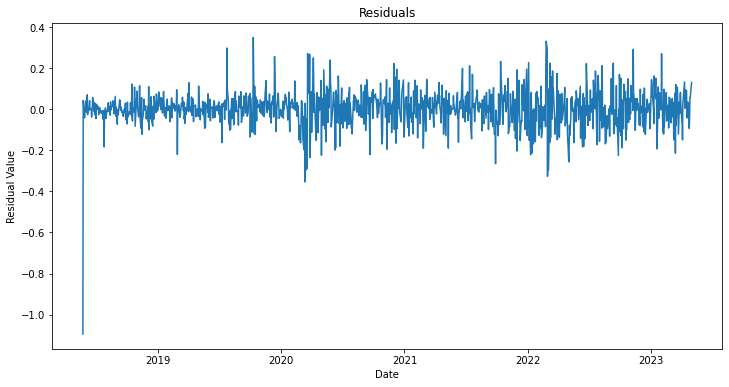

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2798.680, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2802.798, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2802.067, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2799.337, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2805.902, Time=0.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2805.115, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2804.640, Time=1.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2803.167, Time=1.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2803.294, Time=3.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2806.879, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2803.633, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2806.027, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2805.592, Time=1.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2804.115, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1246
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1406.439
Date:                Sat, 21 Oct 2023   AIC                          -2806.879
Time:                        14:16:36   BIC                          -2791.498
Sample:                             0   HQIC                         -2801.095
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0666      0.025      2.615      0.009       0.017       0.116
ar.L2          0.0649      0.019      3.372      0.001       0.027       0.103
sigma2         0.0061      0.000     58.922      0.0

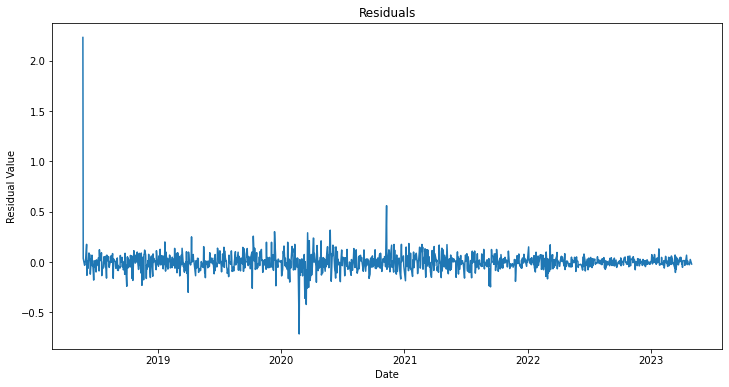

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-687.373, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-876.525, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-908.053, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-689.324, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-906.227, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-906.211, Time=1.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-904.366, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-909.861, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-908.040, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-908.024, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-878.414, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-906.179, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.455 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  DPH.L   No. Observations:                 1238
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 456.931
Date:                Sat, 21 Oct 2023   AIC                           -909.861
Time:                        14:16:43   BIC                           -899.620
Sample:                             0   HQIC                          -906.009
                               - 1238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4388      0.003   -149.951      0.000      -0.445      -0.433
sigma2         0.0280   9.04e-05    309.426      0.000       0.028       0.028
Ljung-Box (L1) (Q):                   0.04   Jarque-

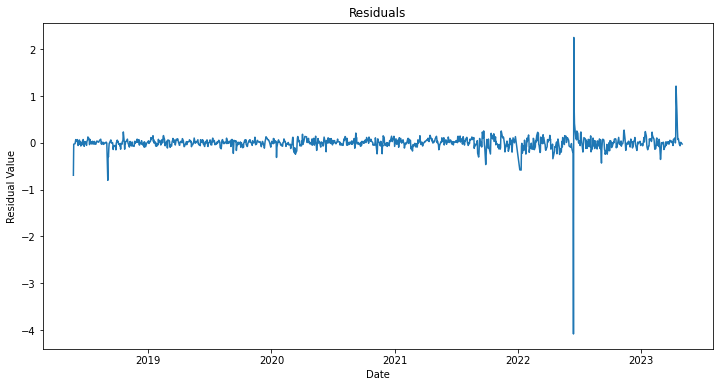

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-364.713, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-562.118, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-621.490, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-366.688, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-620.650, Time=2.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-620.528, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-619.073, Time=2.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-623.372, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-622.525, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-622.404, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-564.060, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-620.945, Time=0.87 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.593 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 INCH.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 313.686
Date:                Sat, 21 Oct 2023   AIC                           -623.372
Time:                        14:16:53   BIC                           -613.116
Sample:                             0   HQIC                          -619.516
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4950      0.003   -167.658      0.000      -0.501      -0.489
sigma2         0.0354      0.000    334.685      0.000       0.035       0.036
Ljung-Box (L1) (Q):                   0.25   Jarque-

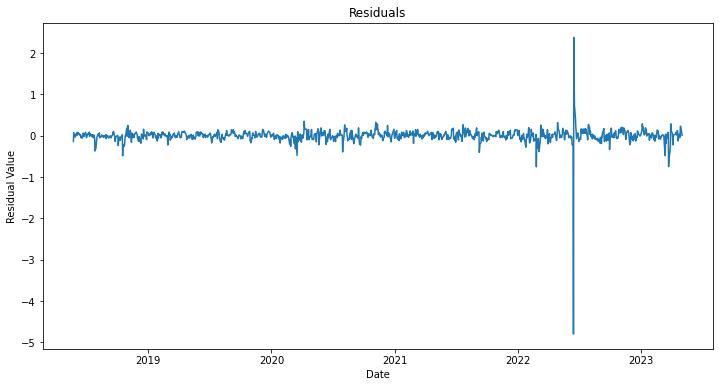

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2784.654, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2786.119, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2786.314, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2786.280, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2784.508, Time=1.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2784.884, Time=1.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2785.489, Time=3.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2787.979, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2786.125, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2786.535, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2787.785, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2787.170, Time=1.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 10.358 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  MKS.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1395.990
Date:                Sat, 21 Oct 2023   AIC                          -2787.979
Time:                        14:17:04   BIC                          -2777.724
Sample:                             0   HQIC                         -2784.124
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0562      0.021      2.716      0.007       0.016       0.097
sigma2         0.0062      0.000     58.922      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   0.00   Jarque-

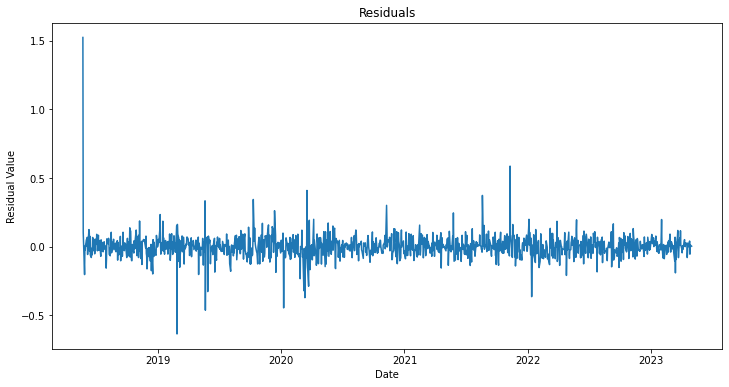

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1337.534, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1340.550, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1340.324, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1338.911, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1339.177, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1339.173, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1337.240, Time=2.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1341.849, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1340.504, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1340.488, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1341.623, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1338.564, Time=0.66 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 9.331 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1247
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 672.925
Date:                Sat, 21 Oct 2023   AIC                          -1341.849
Time:                        14:17:15   BIC                          -1331.594
Sample:                             0   HQIC                         -1337.993
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0629      0.022     -2.868      0.004      -0.106      -0.020
sigma2         0.0199      0.000     44.837      0.000       0.019       0.021
Ljung-Box (L1) (Q):                   0.00   Jarque-

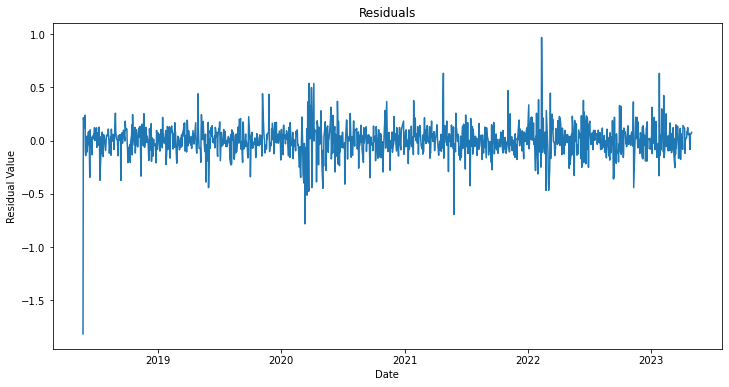

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2034.365, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2202.309, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2223.642, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2035.812, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2222.216, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2222.208, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2220.217, Time=2.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2223.878, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2222.519, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2222.515, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2203.144, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2220.055, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.672 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  GAW.L   No. Observations:                 1246
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1113.939
Date:                Sat, 21 Oct 2023   AIC                          -2223.878
Time:                        14:17:24   BIC                          -2213.624
Sample:                             0   HQIC                         -2220.022
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3970      0.003   -123.307      0.000      -0.403      -0.391
sigma2         0.0098   3.48e-05    280.760      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.15   Jarque-

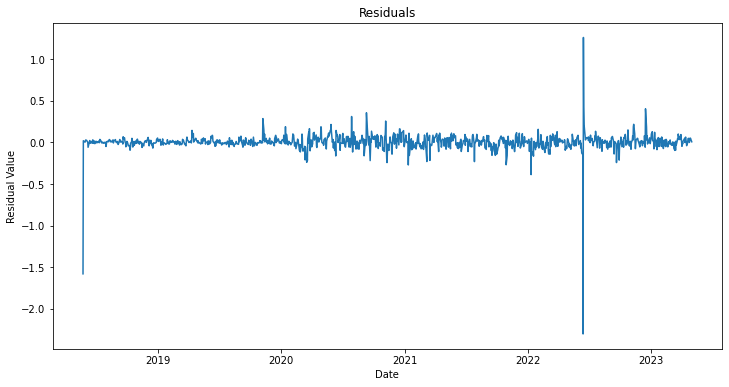

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1839.644, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1837.808, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1837.795, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1841.642, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1836.200, Time=2.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.806 seconds
                               SARIMAX Results                                
Dep. Variable:                 WIZZ.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 921.821
Date:                Sat, 21 Oct 2023   AIC                          -1841.642
Time:                        14:17:29   BIC                          -1836.514
Sample:                             0   HQIC                         -1839.714
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


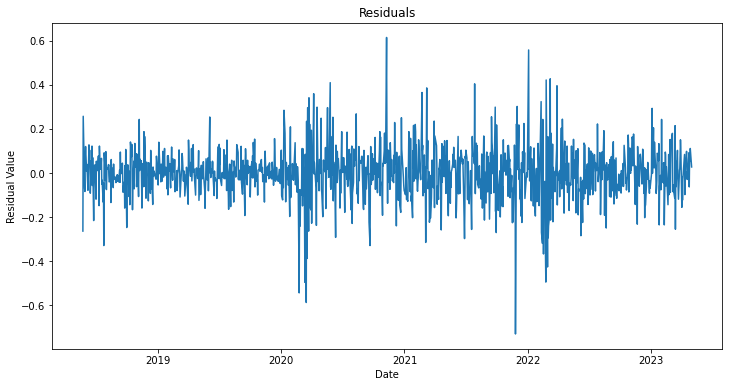

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2181.376, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2179.621, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2179.616, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2182.970, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2177.376, Time=0.77 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.071 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1092.485
Date:                Sat, 21 Oct 2023   AIC                          -2182.970
Time:                        14:17:33   BIC                          -2177.842
Sample:                             0   HQIC                         -2181.042
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0101      0.000     84.639      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):             23108.91
Prob(Q):                              0.62   Pr

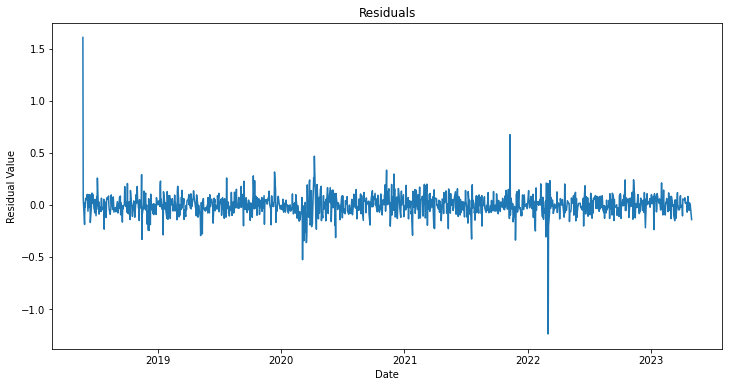

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1637.789, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1637.395, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1637.176, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1639.775, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1641.696, Time=1.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1641.151, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1641.101, Time=1.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1642.871, Time=0.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1641.033, Time=2.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1640.235, Time=2.96 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1644.860, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1639.163, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1643.090, Time=0.64 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1643.022, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  BWY.L   No. Observations:                 1246
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 825.430
Date:                Sat, 21 Oct 2023   AIC                          -1644.860
Time:                        14:17:49   BIC                          -1629.480
Sample:                             0   HQIC                         -1639.077
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0350      0.022      1.586      0.113      -0.008       0.078
ma.L2          0.0775      0.021      3.702      0.000       0.036       0.119
sigma2         0.0155      0.000     45.471      0.0

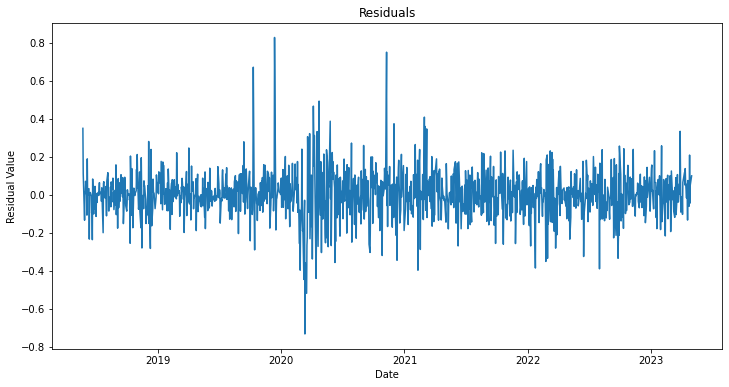

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2577.474, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2580.961, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2580.762, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2579.409, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2579.373, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2579.400, Time=1.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2577.343, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2582.886, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2581.302, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2581.327, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2582.686, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2579.271, Time=0.55 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.605 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


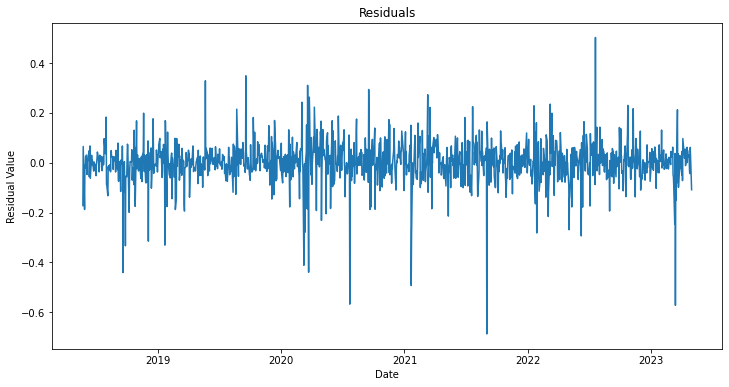

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=621.240, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=425.409, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=372.361, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=619.241, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=372.364, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=372.787, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=372.497, Time=1.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=370.367, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=370.371, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=370.793, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=423.412, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=370.504, Time=0.61 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.407 seconds
                               SARIMAX Results                                
Dep. Variable:       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


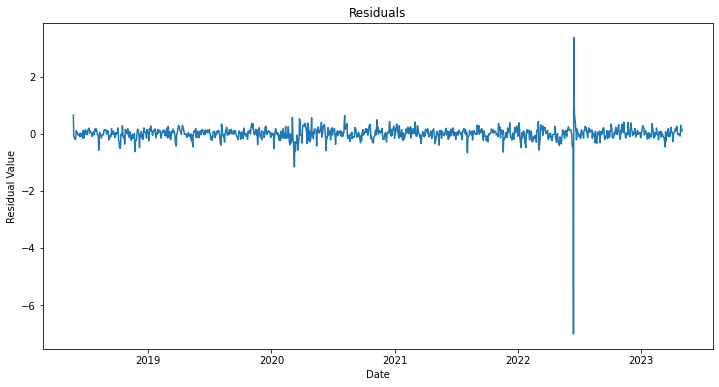

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4081.007, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4083.546, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4083.682, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4077.641, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4081.936, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4081.892, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4079.886, Time=1.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4080.923, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.599 seconds
                               SARIMAX Results                                
Dep. Variable:                  TUI.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2042.462
Date:                Sat, 21 Oct 2023   AIC                          -4080.923
Time:                       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


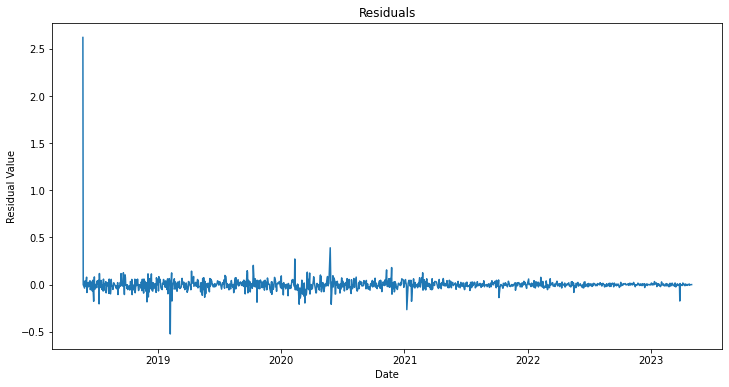

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2866.811, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2865.054, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2865.020, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2867.198, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2865.316, Time=1.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.208 seconds
                               SARIMAX Results                                
Dep. Variable:                  GRG.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1434.599
Date:                Sat, 21 Oct 2023   AIC                          -2867.198
Time:                        14:18:09   BIC                          -2862.070
Sample:                             0   HQIC                         -2865.270
                               - 1247                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


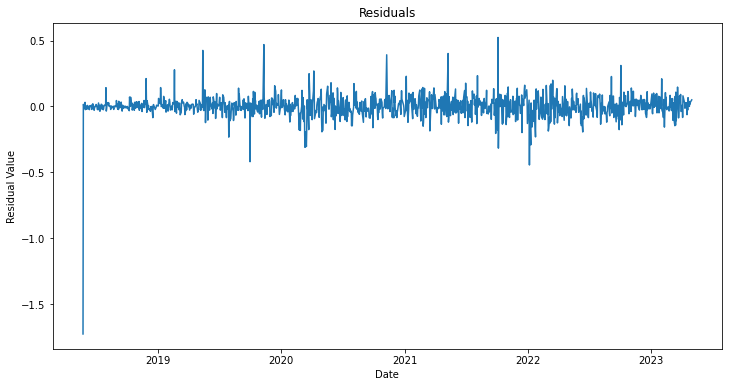

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-403.544, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-642.098, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-735.887, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-405.528, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-735.114, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-734.988, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-732.182, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-737.776, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-736.995, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-736.871, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-644.057, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-734.070, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.549 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BBOX.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 370.888
Date:                Sat, 21 Oct 2023   AIC                           -737.776
Time:                        14:18:15   BIC                           -727.520
Sample:                             0   HQIC                          -733.920
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5720      0.003   -186.596      0.000      -0.578      -0.566
sigma2         0.0323   8.16e-05    395.621      0.000       0.032       0.032
Ljung-Box (L1) (Q):                   0.34   Jarque-

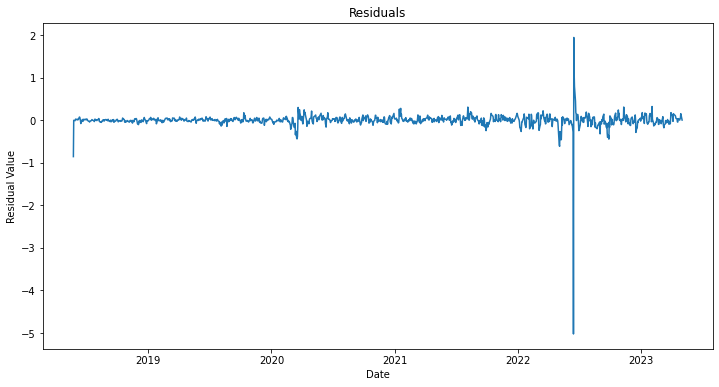

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1911.247, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1910.417, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1910.255, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1913.205, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1921.158, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1921.620, Time=2.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1916.583, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1919.792, Time=2.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1919.754, Time=3.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1921.002, Time=0.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1917.247, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1918.244, Time=2.78 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1923.600, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1923.137, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VTY.L   No. Observations:                 1247
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 965.800
Date:                Sat, 21 Oct 2023   AIC                          -1923.600
Time:                        14:18:37   BIC                          -1903.089
Sample:                             0   HQIC                         -1915.888
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7682      0.088      8.756      0.000       0.596       0.940
ar.L2          0.0509      0.026      1.966      0.049       0.000       0.102
ma.L1         -0.7489      0.084     -8.910      0.0

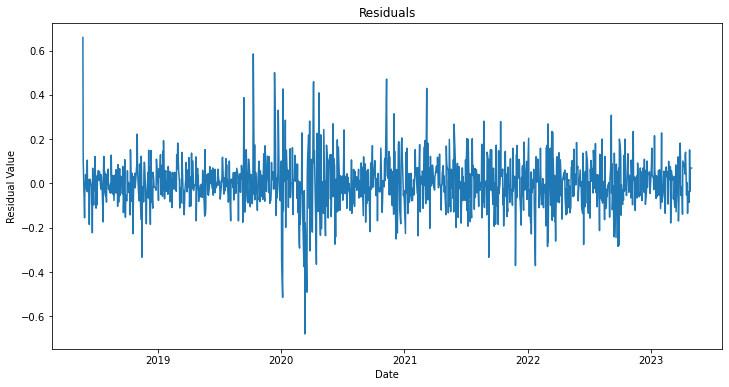

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3245.570, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3243.947, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3243.926, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3246.921, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3241.750, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.715 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  CCC.L   No. Observations:                 1247
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1624.460
Date:                Sat, 21 Oct 2023   AIC                          -3246.921
Time:                        14:18:40   BIC                          -3241.793
Sample:                             0   HQIC                         -3244.993
                               - 1247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0043   7.86e-05     54.931      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):              3066.11
Prob(Q):                              0.54   Pr

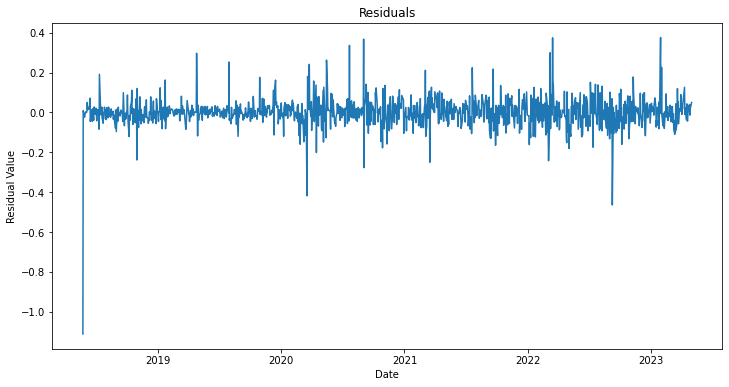

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [16]:
dict_df_T = dict_df.T
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction
BEZ.L,0.0,0.0,1.0,1.291763
PSN.L,0.0,0.0,1.0,-0.914581
HSX.L,0.0,0.0,1.0,0.351898
RS1.L,0.0,0.0,1.0,0.617957
UTG.L,1.0,0.0,1.0,0.049140
JMAT.L,0.0,0.0,1.0,-1.202156
BLND.L,0.0,0.0,1.0,-0.933757
FRAS.L,0.0,0.0,1.0,1.443389
OCDO.L,0.0,0.0,1.0,-1.475248
CCL.L,0.0,0.0,1.0,-1.076338


In [17]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-8])
dict_df_T["naive_prediction"] = naive_predictions


In [18]:
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BEZ.L,0.0,0.0,1.0,1.291763,1.235683
PSN.L,0.0,0.0,1.0,-0.914581,-1.269536
HSX.L,0.0,0.0,1.0,0.351898,0.253169
RS1.L,0.0,0.0,1.0,0.617957,0.545405
UTG.L,1.0,0.0,1.0,0.049140,0.071105
JMAT.L,0.0,0.0,1.0,-1.202156,-1.182126
BLND.L,0.0,0.0,1.0,-0.933757,-1.071874
FRAS.L,0.0,0.0,1.0,1.443389,1.507023
OCDO.L,0.0,0.0,1.0,-1.475248,-1.455126
CCL.L,0.0,0.0,1.0,-1.076338,-1.087122


In [19]:
#verifying that the naive prediction is identical with the actual price.iloc[-8]

df_standardised.iloc[-8] == dict_df_T["naive_prediction"]

Ticker_Symbol
BEZ.L     True
PSN.L     True
HSX.L     True
RS1.L     True
UTG.L     True
JMAT.L    True
BLND.L    True
FRAS.L    True
OCDO.L    True
CCL.L     True
IMI.L     True
INVP.L    True
HIK.L     True
ICP.L     True
DPLM.L    True
SXS.L     True
HWDN.L    True
EZJ.L     True
DPH.L     True
INCH.L    True
MKS.L     True
TATE.L    True
GAW.L     True
WIZZ.L    True
ITV.L     True
BWY.L     True
IGG.L     True
ROR.L     True
TUI.L     True
GRG.L     True
BBOX.L    True
VTY.L     True
CCC.L     True
dtype: bool

In [20]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BEZ.L     False
PSN.L     False
HSX.L     False
RS1.L     False
UTG.L     False
JMAT.L    False
BLND.L    False
FRAS.L    False
OCDO.L    False
CCL.L     False
IMI.L     False
INVP.L    False
HIK.L     False
ICP.L     False
DPLM.L    False
SXS.L     False
HWDN.L    False
EZJ.L     False
DPH.L     False
INCH.L    False
MKS.L     False
TATE.L    False
GAW.L     False
WIZZ.L    False
ITV.L     False
BWY.L     False
IGG.L     False
ROR.L     False
TUI.L     False
GRG.L     False
BBOX.L    False
VTY.L     False
CCC.L     False
dtype: bool

In [21]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

False    33
Name: count, dtype: int64

In [22]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BEZ.L,0.0,0.0,1.0,1.291763,1.235683
PSN.L,0.0,0.0,1.0,-0.914581,-1.269536
HSX.L,0.0,0.0,1.0,0.351898,0.253169
RS1.L,0.0,0.0,1.0,0.617957,0.545405
UTG.L,1.0,0.0,1.0,0.049140,0.071105
JMAT.L,0.0,0.0,1.0,-1.202156,-1.182126
BLND.L,0.0,0.0,1.0,-0.933757,-1.071874
FRAS.L,0.0,0.0,1.0,1.443389,1.507023
OCDO.L,0.0,0.0,1.0,-1.475248,-1.455126
CCL.L,0.0,0.0,1.0,-1.076338,-1.087122


In [23]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [24]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

comparision_df["Actual Price, y"] =\
(
        actual_price_df.loc[comparision_df.index].values
)


In [25]:
comparision_df

,ARIMA_prediction,naive_prediction
BEZ.L,1.291763,1.235683
PSN.L,-0.914581,-1.269536
HSX.L,0.351898,0.253169
RS1.L,0.617957,0.545405
UTG.L,0.049140,0.071105
JMAT.L,-1.202156,-1.182126
BLND.L,-0.933757,-1.071874
FRAS.L,1.443389,1.507023
OCDO.L,-1.475248,-1.455126
CCL.L,-1.076338,-1.087122


In [26]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y"
BEZ.L,1.291763,1.235683,1.468969
PSN.L,-0.914581,-1.269536,-1.286969
HSX.L,0.351898,0.253169,0.392203
RS1.L,0.617957,0.545405,0.085076
UTG.L,0.049140,0.071105,-0.386824
JMAT.L,-1.202156,-1.182126,-1.464454
BLND.L,-0.933757,-1.071874,-1.661885
FRAS.L,1.443389,1.507023,0.910854
OCDO.L,-1.475248,-1.455126,-1.607938
CCL.L,-1.076338,-1.087122,-0.974318


In [27]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BEZ.L,1.291763,1.235683,1.468969,0.031402,0.054422
PSN.L,-0.914581,-1.269536,-1.286969,0.138673,0.000304
HSX.L,0.351898,0.253169,0.392203,0.001625,0.019330
RS1.L,0.617957,0.545405,0.085076,0.283961,0.211902
UTG.L,0.049140,0.071105,-0.386824,0.190065,0.209700
JMAT.L,-1.202156,-1.182126,-1.464454,0.068800,0.079709
BLND.L,-0.933757,-1.071874,-1.661885,0.530170,0.348113
FRAS.L,1.443389,1.507023,0.910854,0.283593,0.355417
OCDO.L,-1.475248,-1.455126,-1.607938,0.017607,0.023352
CCL.L,-1.076338,-1.087122,-0.974318,0.010408,0.012725


In [28]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y"
BEZ.L,0.0,0.0,1.0,1.291763,1.235683,1.468969
PSN.L,0.0,0.0,1.0,-0.914581,-1.269536,-1.286969
HSX.L,0.0,0.0,1.0,0.351898,0.253169,0.392203
RS1.L,0.0,0.0,1.0,0.617957,0.545405,0.085076
UTG.L,1.0,0.0,1.0,0.049140,0.071105,-0.386824
JMAT.L,0.0,0.0,1.0,-1.202156,-1.182126,-1.464454
BLND.L,0.0,0.0,1.0,-0.933757,-1.071874,-1.661885
FRAS.L,0.0,0.0,1.0,1.443389,1.507023,0.910854
OCDO.L,0.0,0.0,1.0,-1.475248,-1.455126,-1.607938
CCL.L,0.0,0.0,1.0,-1.076338,-1.087122,-0.974318


In [29]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BEZ.L,0.0,0.0,1.0,1.291763,1.235683,1.468969,0.031402,0.054422
PSN.L,0.0,0.0,1.0,-0.914581,-1.269536,-1.286969,0.138673,0.000304
HSX.L,0.0,0.0,1.0,0.351898,0.253169,0.392203,0.001625,0.019330
RS1.L,0.0,0.0,1.0,0.617957,0.545405,0.085076,0.283961,0.211902
UTG.L,1.0,0.0,1.0,0.049140,0.071105,-0.386824,0.190065,0.209700
JMAT.L,0.0,0.0,1.0,-1.202156,-1.182126,-1.464454,0.068800,0.079709
BLND.L,0.0,0.0,1.0,-0.933757,-1.071874,-1.661885,0.530170,0.348113
FRAS.L,0.0,0.0,1.0,1.443389,1.507023,0.910854,0.283593,0.355417
OCDO.L,0.0,0.0,1.0,-1.475248,-1.455126,-1.607938,0.017607,0.023352
CCL.L,0.0,0.0,1.0,-1.076338,-1.087122,-0.974318,0.010408,0.012725


In [30]:
dict_df_T[dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]]

#observation: if p = 0 and q = 0, ARIMA_prediction = naive_prediction

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive


In [31]:
dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BEZ.L,0.0,0.0,1.0,1.291763,1.235683,1.468969,0.031402,0.054422
PSN.L,0.0,0.0,1.0,-0.914581,-1.269536,-1.286969,0.138673,0.000304
HSX.L,0.0,0.0,1.0,0.351898,0.253169,0.392203,0.001625,0.019330
RS1.L,0.0,0.0,1.0,0.617957,0.545405,0.085076,0.283961,0.211902
UTG.L,1.0,0.0,1.0,0.049140,0.071105,-0.386824,0.190065,0.209700
JMAT.L,0.0,0.0,1.0,-1.202156,-1.182126,-1.464454,0.068800,0.079709
BLND.L,0.0,0.0,1.0,-0.933757,-1.071874,-1.661885,0.530170,0.348113
FRAS.L,0.0,0.0,1.0,1.443389,1.507023,0.910854,0.283593,0.355417
OCDO.L,0.0,0.0,1.0,-1.475248,-1.455126,-1.607938,0.017607,0.023352
CCL.L,0.0,0.0,1.0,-1.076338,-1.087122,-0.974318,0.010408,0.012725


In [32]:
#confusion matrix

#define positive, with reference to the rank of the 35 stocks at balancing date.
#need to multiply the actual price(un-normalised) * number of outstanding share
#postive result is reflected as 1 when the market cap of the 35 stocks are above the lowest of the 100th market cap. 

#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_price"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_price", "un-normalised_ARIMA_pred", "un-normalised_naive_pred"]].mul(symbols_["Shares"].loc[dict_df_T.index], axis=0)
result

#np.dot(actual_price_df.T, ticker_std_df) + ticker_mean_df

#dict_df_T["Actual_price_un-normoralised"] = pd.DataFrame(np.dot(actual_price_df.T, ticker_mean_df).T)

,un-normalised_actual_price,un-normalised_ARIMA_pred,un-normalised_naive_pred
BEZ.L,401935.481829,390436.061363,386796.887325
PSN.L,381833.251524,431020.330473,384135.845882
HSX.L,388180.830294,384591.882921,375800.699098
RS1.L,371503.116466,422336.216125,415415.277818
UTG.L,278865.617696,296658.401422,297554.844016
JMAT.L,313339.043031,333986.556296,335563.222129
BLND.L,308716.925682,349722.299218,341944.091179
FRAS.L,87421.047168,101070.205103,102701.174569
OCDO.L,245860.772861,293854.408756,301132.543159
CCL.L,115718.345839,96490.330410,94457.831733


In [33]:
result["un-normalised_actual_price"].sort_values(ascending=False)
result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
result["un-normalised_naive_pred"].sort_values(ascending=False)

RS1.L     415415.277818
DPH.L     412010.902776
IMI.L     399369.611928
SXS.L     393858.739786
BEZ.L     386796.887325
PSN.L     384135.845882
HSX.L     375800.699098
HWDN.L    356342.056938
DPLM.L    348704.874497
ICP.L     343104.065281
BLND.L    341944.091179
JMAT.L    335563.222129
TATE.L    323431.640513
MKS.L     321995.692329
EZJ.L     315715.430780
GAW.L     312066.027736
OCDO.L    301132.543159
UTG.L     297554.844016
ITV.L     292066.174405
HIK.L     289503.204766
BWY.L     279978.622536
GRG.L     276337.296800
INCH.L    272655.002430
IGG.L     271853.441697
BBOX.L    269975.871608
ROR.L     269621.369063
INVP.L    264246.998345
VTY.L     259865.179358
TUI.L     226513.062516
WIZZ.L    215221.768965
CCC.L     168579.740667
FRAS.L    102701.174569
CCL.L      94457.831733
Name: un-normalised_naive_pred, dtype: float64

In [34]:
result["un-normalised_actual_price"].sort_values(ascending=False)
actual = result["un-normalised_actual_price"].sort_values(ascending=False)
actual_tidied = actual.reset_index().rename(columns = {"index" : "Ticker"})
actual_tidied[["Ticker"]]

,Ticker
0,IMI.L
1,BEZ.L
2,HSX.L
3,DPLM.L
4,SXS.L
5,PSN.L
6,RS1.L
7,ICP.L
8,MKS.L
9,HWDN.L


In [35]:
result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
ARIMA = result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
ARIMA_tidied = ARIMA.reset_index().rename(columns = {"index" : "Ticker"})
ARIMA_tidied[["Ticker"]]

,Ticker
0,PSN.L
1,RS1.L
2,DPH.L
3,IMI.L
4,BEZ.L
5,HSX.L
6,SXS.L
7,HWDN.L
8,DPLM.L
9,BLND.L


In [36]:
result["un-normalised_naive_pred"].sort_values(ascending=False)
naive = result["un-normalised_naive_pred"].sort_values(ascending=False)
naive_tidied = naive.reset_index().rename(columns = {"index" : "Ticker"})
naive_tidied[["Ticker"]]

,Ticker
0,RS1.L
1,DPH.L
2,IMI.L
3,SXS.L
4,BEZ.L
5,PSN.L
6,HSX.L
7,HWDN.L
8,DPLM.L
9,ICP.L


In [40]:
######
#change in FTSE100 (focusing on exit)

#being NOT included in ftse100 is positive result 
def is_excluded_FTSE100(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    top_10_rank = model_df.loc[:10]
    
    true_count = 0
    #false_count = 0
    
    for rank in top_10_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if not actual_tidied.loc[:10].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_positive = true_count / len(actual_tidied)
    false_positive = (10 - true_count) / len(actual_tidied)
    
    return true_positive, false_positive

#being included in ftse100 is negative result 
def is_included_FTSE100(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    top_10_rank = model_df.loc[:10]
    
    true_count = 0
    #false_count = 0
    
    for rank in top_10_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[:10].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_negative = true_count / len(actual_tidied) #stated to be included in top 10 and it is in top 10
    false_negative = (10 - true_count) / len(actual_tidied) #stated to be included but not included in top 10
    
    return true_negative, false_negative

In [41]:
######
#change in FTSE250 (focusing on enter)

#being included in ftse250 is positive result 
def is_included_FTSE250(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    bottom_25_rank = model_df.loc[10:]
    
    true_count = 0
    #false_count = 0
    
    for rank in bottom_25_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[10:].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_positive = true_count / len(actual_tidied)
    false_positive = (len(actual_tidied.iloc[10:]) - true_count) / len(actual_tidied)
    
    return true_positive, false_positive

#being excluded in ftse250 is negative result 
def is_excluded_FTSE250(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    bottom_25_rank = model_df.loc[10:]
    
    true_count = 0
    #false_count = 0
    
    for rank in bottom_25_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[10:].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_negative = true_count / len(actual_tidied) #stated to be included in top 10 and it is in top 10
    false_negative = (len(actual_tidied.iloc[10:]) - true_count) / len(actual_tidied) #stated to be included but not included in top 10
    
    return true_negative, false_negative

In [42]:
true_positive_naive_FTSE100, false_positive_naive_FTSE100 = is_excluded_FTSE100(actual_tidied["Ticker"], naive_tidied["Ticker"])
true_negative_naive_FTSE100, false_negative_naive_FTSE100 = is_included_FTSE100(actual_tidied["Ticker"], naive_tidied["Ticker"])

true_negative_naive_FTSE250, false_negative_naive_FTSE250 = is_excluded_FTSE250(actual_tidied["Ticker"], naive_tidied["Ticker"])
true_postive_naive_FTSE250, false_positive_naive_FTSE250 = is_included_FTSE250(actual_tidied["Ticker"], naive_tidied["Ticker"])

In [43]:
true_positive_ARIMA_FTSE100, false_positive_ARIMA_FTSE100 = is_excluded_FTSE100(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])
true_negative_ARIMA_FTSE100, false_negative_ARIMA_FTSE100 = is_included_FTSE100(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])

true_negative_ARIMA_FTSE250, false_negative_ARIMA_FTSE250 = is_excluded_FTSE250(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])
true_postive_ARIMA_FTSE250, false_positive_ARIMA_FTSE250 = is_included_FTSE250(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])

In [44]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive_FTSE100*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive_FTSE100*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive_FTSE100*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive_FTSE100*100))

Percentage of true positive in naive model is 3.030%
Percentage of true negative in naive model is 30.303%
Percentage of false positive in naive model is 27.273%
Percentage of false negative in naive model is 0.000%


In [45]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA_FTSE100*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA_FTSE100*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA_FTSE100*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA_FTSE100*100))

Percentage of true positive in ARIMA model is 3.030%
Percentage of true negative in ARIMA model is 30.303%
Percentage of false positive in ARIMA model is 27.273%
Percentage of false negative in ARIMA model is 0.000%


In [37]:
actual_tidied[["Ticker"]] == naive_tidied[["Ticker"]]

,Ticker
0,False
1,False
2,False
3,False
4,False
5,True
6,False
7,False
8,False
9,False


In [38]:
actual_tidied[["Ticker"]] == ARIMA_tidied[["Ticker"]]

,Ticker
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


In [39]:
naive_tidied[["Ticker"]] == ARIMA_tidied[["Ticker"]]

,Ticker
0,False
1,False
2,False
3,False
4,True
5,False
6,False
7,True
8,True
9,False
